In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

# Loading data from **lotka_volterra_data.h5**

In [ ]:
with h5py.File("data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

print(np.shape(trajectories))
print(np.shape(time_points))
print(time_points)

## Plot dataset

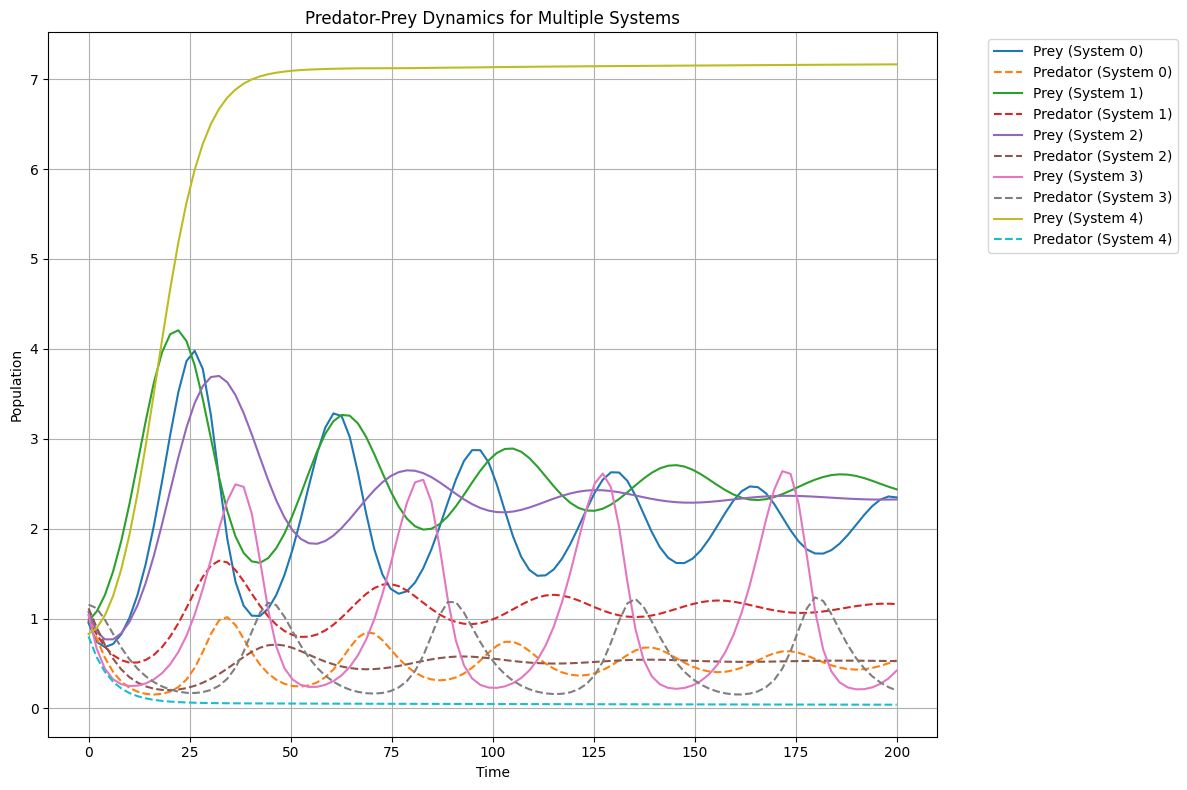

In [3]:
def plot_predator_prey():
    # Plot multiple systems
    num_systems = 5  # Number of systems to plot
    plt.figure(figsize=(12, 8))

    for system_id in range(num_systems):
        prey = trajectories[system_id, :, 0]
        predator = trajectories[system_id, :, 1]
        times = time_points[:]

        # Plot prey and predator population over time
        plt.plot(times, prey, label=f"Prey (System {system_id})", linestyle="-")
        plt.plot(times, predator, label=f"Predator (System {system_id})", linestyle="--")

    # Add labels and legend
    plt.title("Predator-Prey Dynamics for Multiple Systems")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_predator_prey()

# Question 2 (a): LLMTIME Preprocessing Scheme

In [4]:
from src.preprocessor import preprocess_time_series, tokenize_sequence

In [5]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0])
# [16, 13, 17, 18]
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0])
# [16, 659, 220, 17, 220, 18]

[16, 13, 17, 18]
[16, 659, 220, 17, 220, 18]


In [6]:
# Example system
def test(system_id):
    prey = trajectories[system_id, :, 0]
    predator = trajectories[system_id, :, 1]
    data = np.column_stack((prey, predator))

    # Preprocess the data
    preprocessed_sequence = preprocess_time_series(data)
    print("\nPreprocessed Sequence:")
    print(preprocessed_sequence)

    # Tokenize the sequence
    tokenized_sequence = tokenize_sequence(preprocessed_sequence)
    print("\nTokenized Sequence:")
    print(tokenized_sequence)

test(0)


Preprocessed Sequence:
0.09,0.10;0.07,0.08;0.07,0.06;0.07,0.04;0.08,0.03;0.10,0.02;0.13,0.02;0.16,0.02;0.20,0.02;0.25,0.02;0.30,0.02;0.35,0.02;0.39,0.03;0.40,0.05;0.38,0.06;0.33,0.08;0.26,0.10;0.19,0.10;0.14,0.09;0.11,0.08;0.10,0.06;0.10,0.05;0.11,0.04;0.13,0.03;0.15,0.03;0.18,0.02;0.21,0.02;0.25,0.03;0.28,0.03;0.31,0.03;0.33,0.04;0.33,0.05;0.30,0.07;0.26,0.08;0.22,0.08;0.18,0.08;0.15,0.08;0.13,0.07;0.13,0.06;0.13,0.05;0.14,0.04;0.16,0.04;0.18,0.03;0.20,0.03;0.23,0.03;0.25,0.03;0.28,0.04;0.29,0.05;0.29,0.05;0.27,0.06;0.25,0.07;0.22,0.07;0.19,0.07;0.17,0.07;0.15,0.06;0.15,0.06;0.15,0.05;0.15,0.04;0.17,0.04;0.18,0.04;0.20,0.04;0.22,0.04;0.24,0.04;0.25,0.04;0.26,0.05;0.26,0.05;0.25,0.06;0.24,0.06;0.22,0.07;0.20,0.07;0.18,0.07;0.17,0.06;0.16,0.06;0.16,0.05;0.17,0.05;0.18,0.04;0.19,0.04;0.20,0.04;0.22,0.04;0.23,0.04;0.24,0.05;0.25,0.05;0.25,0.05;0.24,0.06;0.23,0.06;0.21,0.06;0.20,0.06;0.19,0.06;0.18,0.06;0.17,0.06;0.17,0.05;0.18,0.05;0.18,0.05;0.19,0.04;0.20,0.04;0.22,0.04;0.22,0.05;0.23,0

# Question 2 (b): Evaluate the untrained Qwen2.5-Instruct model’s forecasting ability

In [7]:
model = AutoModelForCausalLM.from_pretrained(model_name)

def evaluate_untrained_model(data: np.ndarray, scale: float = 10.0):
    """
    Evaluates the untrained Qwen2.5-Instruct model on preprocessed data.
    
    Args:
        data (np.ndarray): Time-series data (T, 2) of prey and predator, where
            - T = Number of time steps
            - First column = Prey population
            - Second column = Predator population
        scale (float): Scaling factor used for preprocessing.
    
    Returns:
        list[float]: Predicted prey and predator values.
    """
    # Preprocess and tokenize
    preprocessed_sequence = preprocess_time_series(data, scale)
    input_tokens = tokenize_sequence(preprocessed_sequence)
    
    input_tensor = torch.tensor([input_tokens]).to(model.device)

    # Generate prediction
    with torch.no_grad():
        output_tokens = model.generate(
            input_tensor,
            max_new_tokens=20,   # Predict up to 20 tokens (10 pairs of prey and predator)
            num_beams=1,         # Greedy decoding
            temperature=1.0
        )

    # Decode output
    predicted_sequence = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    
    # Post-process back to numeric values
    predicted_values = []
    for step in predicted_sequence.split(";"):
        if "," in step:
            prey, predator = step.split(",")
            predicted_values.append([
                float(prey) * scale, 
                float(predator) * scale
            ])
    
    return predicted_values

    
# Example system
system_id = 0
prey = trajectories[system_id, :, 0]
predator = trajectories[system_id, :, 1]
data = np.column_stack((prey, predator))  # Shape: (T, 2)

# Get model predictions
predicted_values = evaluate_untrained_model(data)

print("\nPredicted Values:")
print(predicted_values)

# Compute metrics
n = min(len(predicted_values), len(data))
actual_values = data[-n:]
predicted_values = predicted_values[-n:]

mae = np.mean(np.abs(predicted_values - actual_values)) # average absolute error
mse = np.mean((predicted_values - actual_values) ** 2) # mean square error

print("\nMean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Predicted Values:
[[0.8999999999999999, 1.0], [0.7000000000000001, 0.8], [0.7000000000000001, 0.6], [0.7000000000000001, 0.4], [0.8, 0.3], [1.0, 0.2], [1.3, 0.2], [1.6, 0.2], [2.0, 0.2], [2.5, 0.2], [3.0, 0.2], [3.5, 0.2], [3.9000000000000004, 0.3], [4.0, 0.5], [3.8, 0.6], [3.3000000000000003, 0.8], [2.6, 1.0], [1.9, 1.0], [1.4000000000000001, 0.8999999999999999], [1.1, 0.8], [1.0, 0.6], [1.0, 0.5], [1.1, 0.4], [1.3, 0.3], [1.5, 0.3], [1.7999999999999998, 0.2], [2.1, 0.2], [2.5, 0.3], [2.8000000000000003, 0.3], [3.1, 0.3], [3.3000000000000003, 0.4], [3.3000000000000003, 0.5], [3.0, 0.7000000000000001], [2.6, 0.8], [2.2, 0.8], [1.7999999999999998, 0.8], [1.5, 0.8], [1.3, 0.7000000000000001], [1.3, 0.6], [1.3, 0.5], [1.4000000000000001, 0.4], [1.6, 0.4], [1.7999999999999998, 0.3], [2.0, 0.3], [2.3000000000000003, 0.3], [2.5, 0.3], [2.8000000000000003, 0.4], [2.9, 0.5], [2.9, 0.5], [2.7, 0.6], [2.5, 0.7000000000000001], [2.2, 0.7000000000000001], [1.9, 0.7000000000000001], [1.70000000000

# Question 2 (c): FLOPS

In [35]:
def calculate_flops(num_layers, seq_length, d_model):
    """
    Calculate FLOPS for a transformer model.

    Args:
        num_layers (int): Number of transformer layers.
        seq_length (int): Input sequence length.
        d_model (int): Hidden size.

    Returns:
        forward_flops (float): FLOPS for forward pass.
        backward_flops (float): FLOPS for backward pass.
    """
    # Attention FLOPS
    attention_flops = (
        3 * seq_length * d_model**2 +
        seq_length**2 * d_model +
        seq_length**2 * 11 +
        seq_length**2 * d_model +
        seq_length * d_model**2
    )

    # Feedforward FLOPS
    ff_flops = (
        4 * seq_length * d_model**2 +
        8 * seq_length * d_model +
        4 * seq_length * d_model**2
    )

    # RMSNorm FLOPS
    norm_flops = seq_length * d_model * 2

    # Residual Connection FLOPS
    residual_flops = 2 * seq_length * d_model

    # FLOPS per layer
    flops_per_layer = attention_flops + ff_flops + norm_flops + residual_flops

    # Total FLOPS
    forward_flops = num_layers * flops_per_layer
    backward_flops = 2 * forward_flops

    return forward_flops, backward_flops

# Example:
num_layers = 24      # 24 transformer layers
seq_length = 512     # 512 token input length
d_model = 768        # 768-dimensional hidden size

forward_flops, backward_flops = calculate_flops(num_layers, seq_length, d_model)

print(f"Forward FLOPS: {forward_flops:.2e}")
print(f"Backward FLOPS: {backward_flops:.2e}")


Forward FLOPS: 9.68e+10
Backward FLOPS: 1.94e+11
